# Convolutional Neural Networks (CNN)
Convolutional neural networks (CNN) are a type of artificial neural network especially designed for processing images, i.e. matrices of color intensity values. There are various kinds of layers in a CNN, but a typical architecture is to build a sequence of *convolutional* layers that find patterns in individual areas of the input matrix and *pooling* layers that aggregate these patterns. The final layers *flatten* the matrix data in order to perform classification with a standard *dense* or *fully connected* layer.

This exercise applies CNNs to a very small dataset in order to avoid heavy calculations that would require a GPU on your laptop. The dataset is called [messy vs clean](https://www.kaggle.com/cdawn1/messy-vs-clean-room?) and contains images of either messy or clean rooms. Our job is it to predict whether a given image shows a messy or clean room - if only my bedroom whould look as clean as the following ...

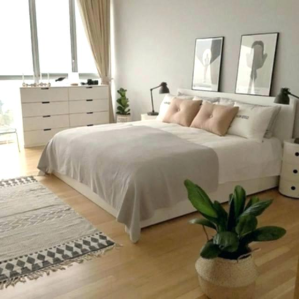

### Import Libraries
If an error message shows up saying that a particular library is not available, you can install it using `pip install [library]`. This notebook uses the newest TensorFlow version 2.3.1. If you have installed an older version, make sure to update it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Auxiliary libraries for system paths, time measurement, ...
import os
import time
from glob import glob
from collections import Counter

# Libraries for interactive elements in Jupyter notebooks
from ipywidgets import interact

# Libraries for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD, Adam

import warnings
warnings.filterwarnings("ignore")

## Helper Method for Fancy Visualization

The following method plots training and validation accuracy and loss. It is just for printing nice visualizations, you can ignore all this.

In [4]:
def show_history_plots_of_trained_model(history, fill_between=False):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="training accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    if fill_between:
        plt.fill_between(epochs_range, acc, val_acc, color = "lightpink", alpha = 0.4, hatch = "-", label="difference")
    plt.legend(loc="lower right")
    plt.title("training and validation accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="training loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    if fill_between:
        plt.fill_between(epochs_range, loss, val_loss, color = "lightpink", alpha = 0.4, hatch = "-", label="difference")
    plt.legend(loc="upper right")
    plt.title("training and validation loss")
    plt.show()

## Define Parameters

We set the values for training parameters, i.e. how many epochs the model should be trained (1 epoch = 1 iteration over the dataset) and the batch size (number of samples used for gradient computation).

In [3]:
epochs = 30
batch_size = 16
initial_lr = 0.001

img_height = 128
img_width  = 128

train_path = os.getcwd() + "/data/train"
test_path  = os.getcwd() + "/data/test"

num_classes = 2

## Load the Dataset 

For loading the dataset we can directly use TensorFlow's `tf.data.Dataset` API, which provides us with many utility methods. To load an image dataset from the directory, we use the `image_dataset_from_directory()` method. We can specify the `image_size` which automatically resizes the loaded images. Read more about the method and its parameters [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). We will load the training dataset (`train_ds`) first, by setting `subset` to `training`. Afterwards, the validation dataset is loaded (`val_ds`), by setting `subset` to `validation`. For both datasets, a validation split parameter is needed, which states how much of the dataset is used for training and how much for validation.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale")

Found 212 files belonging to 2 classes.
Using 170 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale")

Found 212 files belonging to 2 classes.
Using 42 files for validation.


Let us next examine the loaded data. We start by checking if the expected classes are in the dataset and therefore print the variable `class_names` from the dataset.

In [7]:
class_names = train_ds.class_names
assert num_classes == len(class_names)
class_names

['clean', 'messy']

Let us examine the distribution of labels in both the train and the validation set. Remember that we can only use *accuracy* as quality metric when we are given balanced data.

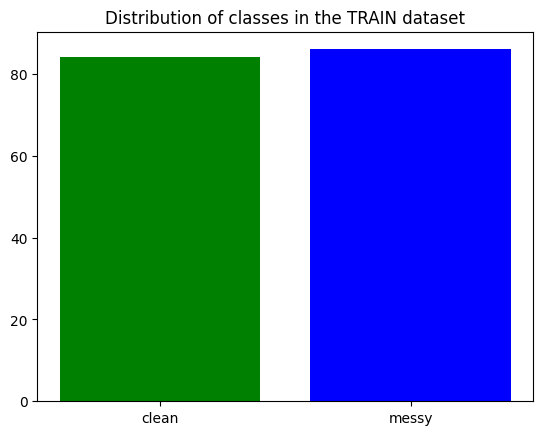

In [12]:
def count_labels(dataset, classnames):
    dictionary = dict.fromkeys(classnames, 0)
    for _, labels in dataset.as_numpy_iterator():
        for i in range(len(classnames)):
            dictionary[classnames[i]] += dict(Counter(labels))[i]
    return dictionary
    
dict_class = count_labels(train_ds, class_names)
plt.bar(dict_class.keys(), dict_class.values(), color=["green", "blue"])
_ = plt.title("Distribution of classes in the TRAIN dataset")

### Exercise

> Adapt the three last code lines in the cell above to display the class labels distribution in the validation set.

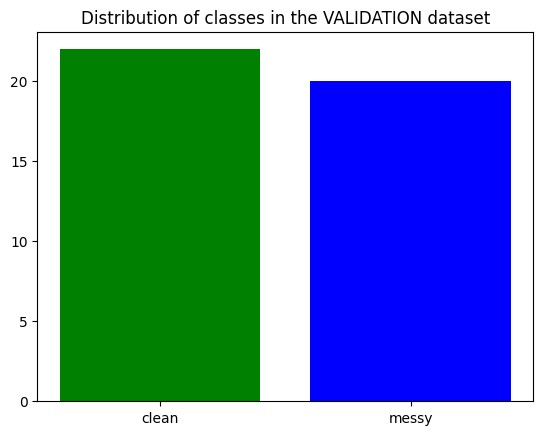

In [13]:
dict_class = count_labels(val_ds, class_names)
plt.bar(dict_class.keys(), dict_class.values(), color=["green", "blue"])
_ = plt.title("Distribution of classes in the VALIDATION dataset")

The datasets are nicely balanced. We next plot a few images with corresponding labels. To do this, we loop over the dataset one image at a time. This can be achieved by calling `.take(1)` from the dataset, which returns $1$ batch of image/labels at a time.

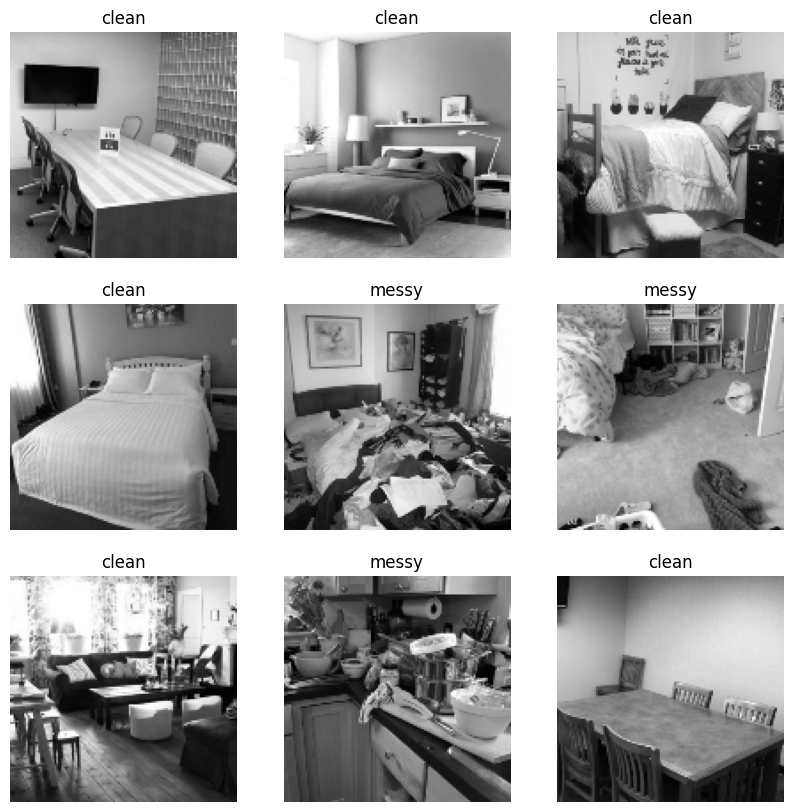

In [15]:
# Specify the figure size of the individual plot
plt.figure(figsize=(10, 10))

# Loop over the dataset by taking one image and label at a time
for images, labels in train_ds.take(1):
    for i in range(9):
        # We display a 3x3 grid of images
        img = np.squeeze(images[i].numpy().astype("uint8"), axis=-1)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

Now we are ready to create our model and print a summary of it. We will start with creating a sequential model, meaning the model is a stack of linear layers with exactly one input and output. Then we first add a rescaling operation to the model, which ensures that all intensity values passed to the model are rescaled to [0, 1]. This is also called a preprocessing layer. After that, we can start with our first convolution layer, which consists of a `Conv2D` layer (convolutional operation) followed by a `MaxPool2D` layer (max-pooling operation). The model consists of three convolution layers in total. Then we add an operation to flatten the output to 1D, to then add two fully connected layers for classification. The last layer produces a probability distribution over the two classes using a softmax. After we finished creating our CNN, we need to compile it using an optimizer, loss function and metrics.

In [21]:
# Create a sequential model, which we will use to add the different layers
model = models.Sequential()

# Rescale the image to range [0, 1] instead of [0, 255]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)))

# 1. convolution layer (32 filters, filter size of 3), followed by a pooling layer
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# 2. convolution layer (64 filters, filter size of 3), followed by a pooling layer
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# 3. convolution layer (64 filters, filter size of 3), followed by a pooling layer
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Flatten the output of the last convolution layer to go from 3 dimensions to 1
model.add(layers.Flatten())

# Add a fully connected layer with 128 neurons
model.add(layers.Dense(128, activation="relu"))

# Output layer, with the number of classes in the dataset as neurons
model.add(layers.Dense(num_classes, activation="relu"))

# Define stochastic gradient descent with a defined learning rate
opt = Adam(learning_rate=initial_lr)

# Compile the model, using the optimizer, cross-entropy loss and accuracy as metric
model.compile(optimizer=opt,loss=keras.losses.CategoricalCrossentropy(),  metrics=[keras.metrics.Accuracy()])

# Print a summary of the created model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)       

The model can be trained using `fit`, where we  specify the training dataset (`train_ds`) as well as the validation dataset (`val_ds`) along with the number of epochs for training.

In [23]:
start = time.time()

# Fit the model on the training dataset and validate it on the validation set
history =  model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

end = time.time()
print("Training took {0:.2f} seconds".format(end-start))

Epoch 1/30
11/11 [==============================] - 2s 114ms/step - loss: 0.7109 - accuracy: 0.5059 - val_loss: 0.6677 - val_accuracy: 0.5952
Epoch 2/30
11/11 [==============================] - 1s 104ms/step - loss: 0.6529 - accuracy: 0.6882 - val_loss: 0.6250 - val_accuracy: 0.6190
Epoch 3/30
11/11 [==============================] - 1s 109ms/step - loss: 0.5863 - accuracy: 0.7235 - val_loss: 0.7601 - val_accuracy: 0.5952
Epoch 4/30
11/11 [==============================] - 1s 115ms/step - loss: 0.4673 - accuracy: 0.7765 - val_loss: 0.6488 - val_accuracy: 0.6905
Epoch 5/30
11/11 [==============================] - 1s 110ms/step - loss: 0.4022 - accuracy: 0.8353 - val_loss: 1.3586 - val_accuracy: 0.5952
Epoch 6/30
11/11 [==============================] - 1s 106ms/step - loss: 0.5301 - accuracy: 0.7529 - val_loss: 0.6638 - val_accuracy: 0.6429
Epoch 7/30
11/11 [==============================] - 1s 106ms/step - loss: 0.3909 - accuracy: 0.8647 - val_loss: 0.6512 - val_accuracy: 0.7143
Epoch 

We plot accuracy and loss of the model on both of the datasets (training and validation).

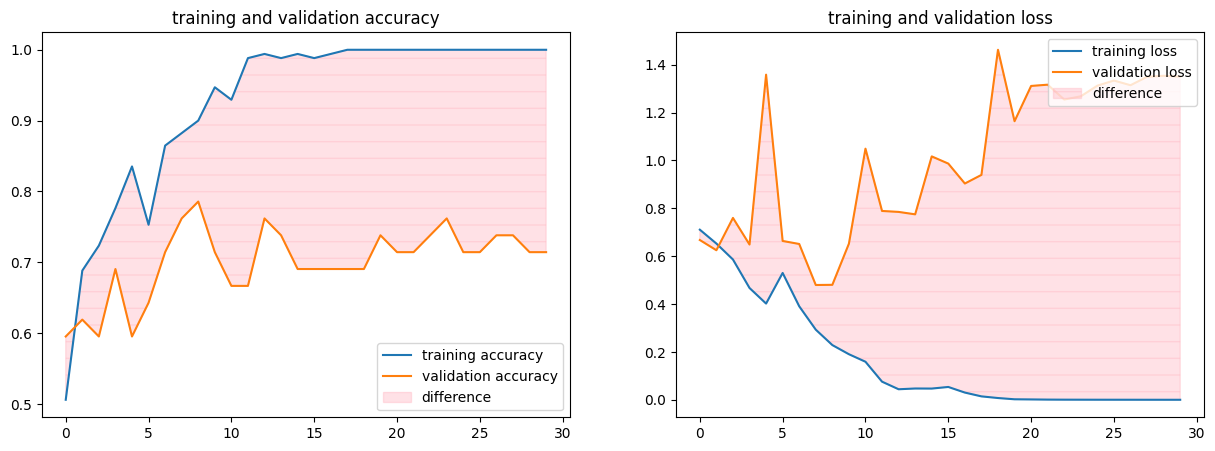

In [24]:
show_history_plots_of_trained_model(history, fill_between=True)

An important aspect of machine learning is to interpret these so-called learning curves. It is very obvious to us that the model greatly overfits the training data. The training accuracy (in the plot on the left) is rising steeply, while the validation accuracy oscillates around $\approx 0.7$. In other word, performance on predicting already seen data improves, but there is no improvement on  fresh data. This typically happens when a machine learning model memorizes data instead of learning patterns and structures, i.e. it leans the training data by heart. This problem is known as **overfitting** and is one of the most common issues to tackle in machine learning. There are many ways to address overfitting; one could:
- add dropout to the model
- constrain the weights of the model
- use data augmentation
- add regularization (e.g. L1, L2)
- reduce model complexity
- ...

However, in this case, we should simply **acquire more data**. The model mostly overfits because there is not enough data to train a reasonable classifier.

# Test the Model on unseen Data

Despite of the expected low performance on unseen data, we can now use the trained model and feed it images from the test set.

In [28]:
test_images = glob(os.path.join(test_path, "*.png"))

@interact(test_image=test_images)
def predict_test_image(test_image):
    img = keras.preprocessing.image.load_img(test_image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.rgb_to_grayscale(img_array)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    txt = "clean prob: {:.3}% \n messy prob: {:.3}%".format( 100*score[0], 100*score[1])
    
    fig = plt.figure()
    plt.imshow(img)
    fig.suptitle(txt, fontsize = 14)
    plt.axis('off')
    plt.show()

interactive(children=(Dropdown(description='test_image', options=('c:\\Users\\David\\Desktop\\HSLU\\sem4\\adml…

Convolutional neural networks are very data hungry and require a lot of computational resources for training. Hence, we cannot train any deeper models on larger datasets without giving you access to GPU resources in the cloud. Still we hopefully could convince you that there is no magic behind image classification with deep learning. Cheers!

# Assignment

> Answer now the Quiz 09A Convolutional Neural Networks